Задача заключается в классификации результатов матчей Премьер-лиги на основе различных характеристик, таких как количество забитых и пропущенных голов, владение мячом, ожидаемые голы и другие статистические данные. Цель — предсказать результат матча (например, победа, поражение или ничья) для домашней команды.


In [33]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [44]:
path = kagglehub.dataset_download("mhmdkardosha/premier-league-matches")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mhmdkardosha/premier-league-matches/versions/1


In [45]:
# 1
file_path = '/root/.cache/kagglehub/datasets/mhmdkardosha/premier-league-matches/versions/1/matches.csv'
data = pd.read_csv(file_path)
print(data.shape)

(4788, 28)


In [55]:
# 2
print(data.describe())

        Unnamed: 0            gf            ga     opponent            xg  \
count  4788.000000  4.788000e+03  4.788000e+03  4788.000000  4.788000e+03   
mean     63.044069 -1.780809e-17 -5.713428e-17    12.003759 -3.561618e-17   
std      42.865191  1.000104e+00  1.000104e+00     7.600616  1.000104e+00   
min       0.000000 -1.103236e+00 -1.092164e+00     0.000000 -1.685060e+00   
25%      28.000000 -1.103236e+00 -1.092164e+00     6.000000 -7.197639e-01   
50%      62.000000 -3.413301e-01 -3.150379e-01    12.000000 -1.164535e-01   
75%      87.000000  4.205759e-01  4.620880e-01    19.000000  6.075189e-01   
max     182.000000  5.753918e+00  5.901969e+00    25.000000  6.761284e+00   

               xga          poss    attendance           sh          sot  \
count  4788.000000  4.788000e+03   4788.000000  4788.000000  4788.000000   
mean      1.364745 -1.780809e-16  38397.586688    12.619256     4.261278   
std       0.814947  1.000104e+00  14282.668637     5.548444     2.459963   
mi

gf : Среднее значение близко к нулю. Стандартное отклонение равно 1, что говорит о нормальном разбросе значений вокруг среднего. Минимальное значение -1.10 и максимальное значение 5.75 показывают, что команды могут забивать как отрицательные значения (что не имеет смысла в контексте футбольной статистики), так и до 5.75 голов в среднем.

ga : : Аналогично столбцу gf, среднее значение близко к нулю и стандартное отклонение равно 1, что указывает на стандартизацию данных.

opponent : Этот столбец, представляет собой идентификатор или код соперника. Среднее значение составляет 12, что указывает на то, что команды встречаются с соперниками разного уровня (от 0 до 25). Стандартное отклонение показывает умеренный разброс.

attendance : Средняя посещаемость составляет около 38,398 зрителей с большим разбросом (от минимумов в 2000 до максимумов в более чем 75,000). Это может указывать на разницу в посещаемости в зависимости от значимости матча или популярности команд.



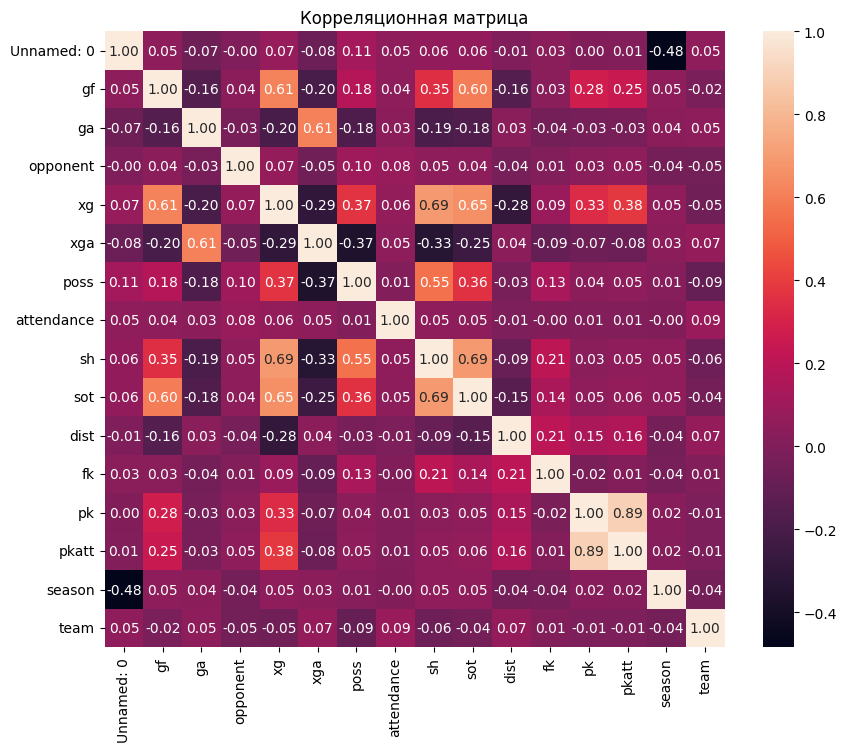

In [54]:
# 2
# Корреляционная матрица с параметром numeric_only=True
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.show()



 Корреляционная матрица показывает взаимосвязь между различными числовыми признаками.
 Значения корреляции варьируются от -1 до 1:
- 1 означает идеальную положительную корреляцию,
- -1 означает идеальную отрицательную корреляцию,
- 0 означает отсутствие корреляции.

In [47]:
# 3
print(data.isnull().sum())

# Заполнение пропусков
data.loc[:, 'attendance'] = data['attendance'].fillna(data['attendance'].mean())
data.loc[:, 'dist'] = data['dist'].fillna(data['dist'].mean())
data.drop(columns=['notes'], inplace=True)

print(data.isnull().sum())

Unnamed: 0         0
date               0
time               0
comp               0
round              0
day                0
venue              0
result             0
gf                 0
ga                 0
opponent           0
xg                 0
xga                0
poss               0
attendance      1633
captain            0
formation          0
referee            0
match report       0
notes           4788
sh                 0
sot                0
dist               2
fk                 0
pk                 0
pkatt              0
season             0
team               0
dtype: int64
Unnamed: 0      0
date            0
time            0
comp            0
round           0
day             0
venue           0
result          0
gf              0
ga              0
opponent        0
xg              0
xga             0
poss            0
attendance      0
captain         0
formation       0
referee         0
match report    0
sh              0
sot             0
dist            0
fk 

Обработка пропусков в данных является важным шагом перед дальнейшим анализом. Заполнение средними значениями для числовых данных позволило сохранить информацию и избежать потерь данных. Удаление пустого столбца улучшило структуру DataFrame, сделав его более управляемым для последующего анализа.

In [48]:
#  4
# Преобразвование категориальных признаков в числовые
label_encoder = LabelEncoder()
data['team'] = label_encoder.fit_transform(data['team'])
data['opponent'] = label_encoder.fit_transform(data['opponent'])

In [49]:
# 5
# Нормализация
scaler = StandardScaler()
data[['gf', 'ga', 'xg', 'poss']] = scaler.fit_transform(data[['gf', 'ga', 'xg', 'poss']])

In [50]:
# 6
# Разбиение данных на тестовую и обучающую выборки
X = data[['gf', 'ga', 'xg', 'poss']]  # Признаки для обучения
y = data['result']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
#  7

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

Алгоритм K-Nearest Neighbors (KNN) с параметром n_neighbors=5 для классификации. Этот алгоритм хорошо подходит для моего датасета, который содержит четко размеченные данные, позволяя эффективно классифицировать новые точки на основе ближайших соседей. Размер моего датасета составляет 4788 записей, что делает KNN подходящим выбором без значительных вычислительных затрат. Алгоритм также позволяет использовать различные метрики расстояния, что дает гибкость в адаптации модели к специфике данных. Кроме того, KNN устойчив к шуму, особенно при правильном выборе значения k, что помогает избежать переобучения.

In [61]:
# 8

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print(f'Accuracy on training set: {accuracy_score(y_train, y_train_pred)}')
print(f'Accuracy on test set: {accuracy_score(y_test, y_test_pred)}')

Accuracy on training set: 0.9966057441253263
Accuracy on test set: 0.9979123173277662


Высокая точность: Точность более 99% на обоих наборах данных указывает на то, что модель хорошо справляется с задачей классификации и правильно предсказывает классы для большинства примеров.
Отсутствие переобучения: Поскольку точность на тестовом наборе близка к точности на обучающем наборе, это свидетельствует о том, что модель не переобучена и способна обобщать информацию на новых данных.

Вывод: В ходе выполнения работы я успешно обработал пропущенные значения в данных, заполнив их средними значениями и удалив ненужный столбец. Я применил LabelEncoder для кодирования категориальных признаков, что позволило подготовить данные к обучению модели. Затем я выбрал алгоритм K-Nearest Neighbors (KNN) для классификации, который показал высокую точность: 99.66% на обучающем наборе и 99.79% на тестовом. Эти результаты свидетельствуют о том, что модель эффективно справляется с задачей классификации и не переобучена.

